In [92]:
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import random
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import normalize
from scipy.stats import zscore
import sys
from sklearn.decomposition import PCA

Question 1

In [2]:
# set given parameter value
AV = [0, 20, 0, 0, 0, 0]
IV = [30, 45, 60, 40, 40, 40]
DO = [15, 20, 25, 15, 20, 25]
N = 240
V = 441
x1 = 21
x2 = 21
L = 6
nsrcs = 6

1.1

In [3]:
# Generate TC data using given vectors
def createTC(av, iv, do):
    TCn = np.zeros(N, dtype=int)
    inc = N/iv
    while inc >= 1:
        for j in range(do):
            TCn[av+j] = 1
        av = av + iv
        inc -= 1
    
    return TCn

TCL = []
for i in range(nsrcs):
    av = AV[i]
    iv = IV[i]
    do = DO[i]
    inc = N/iv
    TCL.append(createTC(av, iv, do))

OTC = np.asmatrix(TCL).transpose()
print(OTC.shape)    

(240, 6)


In [4]:
# Standardise the generated TC data
TC = np.asmatrix(pd.DataFrame(OTC).astype(float).apply(zscore).to_numpy())

In [5]:
# try normalising the TC data instead
NTC = normalize(OTC, axis=0, norm='l2')

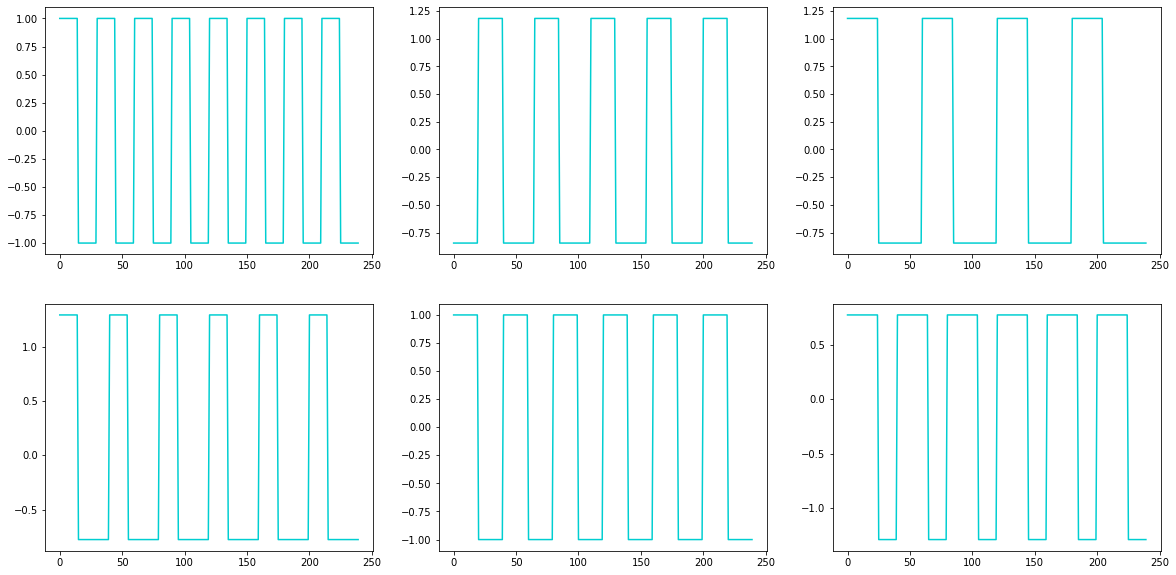

In [6]:
# plotting the TC box-car graphs
x = range(N)
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(20)
TCcolor = "darkturquoise"

for i in range(nsrcs):
    ax = fig.add_subplot(231+i) 
    ax.plot(x, TC[:, i], color = TCcolor)
plt.show()

1.2

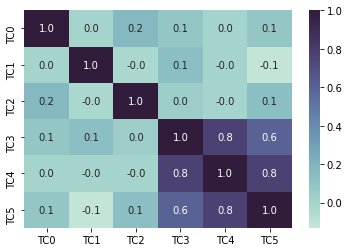

In [7]:
# plot correlation matrix for TC data
TCdf = pd.DataFrame(TC, columns = ["TC0", "TC1", "TC2", "TC3", "TC4", "TC5"])
corr_mat = TCdf.corr()
TCcmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(corr_mat, cmap=TCcmap, annot = True, fmt='.1f')

plt.show()

1.3

In [8]:
# create SM data
def createSM(vs, hs):
    SM = np.zeros((x1, x2), dtype=int)
    for i in range(x1):
        for j in range(x2):
            if i in range(hs[0], hs[1]) and j in range(vs[0], vs[1]):
                SM[i][j] = 1
    return SM

tmpSM = []
tmpSM.append(createSM([2, 6], [2,6]))
tmpSM.append(createSM([2, 6], [15, 19]))
tmpSM.append(createSM([8, 13], [2, 6]))
tmpSM.append(createSM([8, 13], [15, 19]))
tmpSM.append(createSM([15, 19], [2, 6]))
tmpSM.append(createSM([15, 19], [15, 19]))

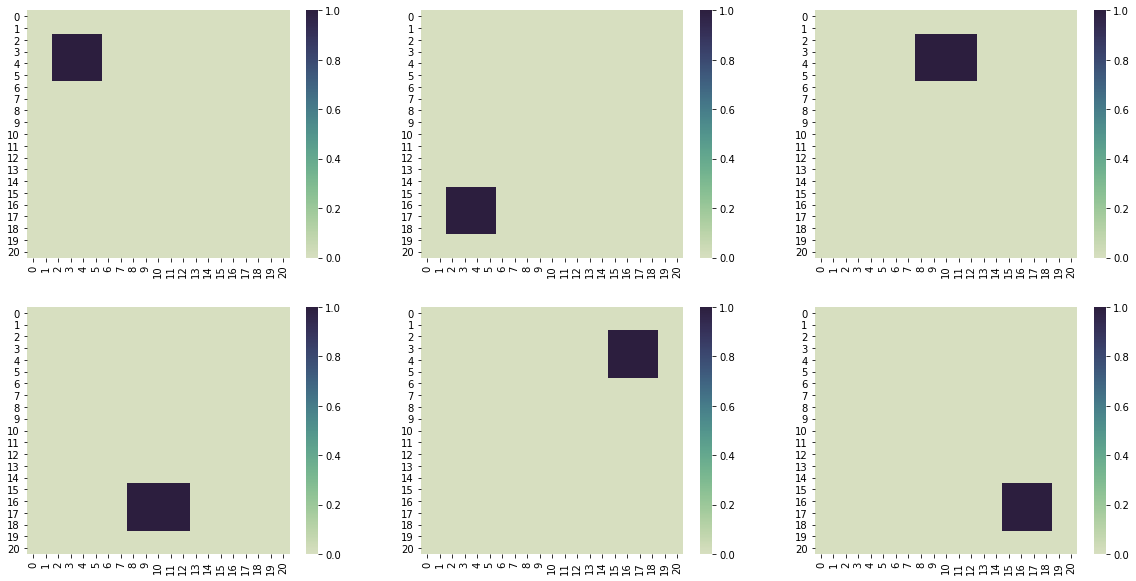

In [10]:
# ploting SM
SMcmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(20)
plt.xlim=(0,22)
plt.ylim=(0,22)

for i in range(nsrcs):
    ax = fig.add_subplot(231+i) 
    sns.heatmap(tmpSM[i], cmap=SMcmap)
plt.show()

In [11]:
# flatten each small SM matrix to create final SM
SM = []
for i in range(nsrcs):
    SM.append(tmpSM[i].flatten())
SM = np.asmatrix(SM)

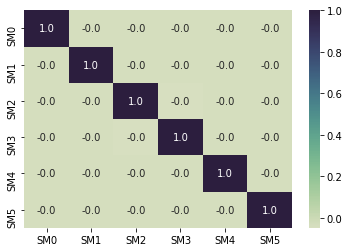

In [13]:
# plot correlation matrix for SM data
SMdf = pd.DataFrame(SM.transpose(), columns = ["SM0", "SM1", "SM2", "SM3", "SM4", "SM5"])
corr_mat = SMdf.corr()
sns.heatmap(corr_mat, cmap=SMcmap, annot = True, fmt='.1f')

plt.show()

1.4

In [14]:
# generate white Gaussian noise for TC and SM
mu = 0
varTC = 0.25
varSM = 0.015
TCnoise = np.random.normal(mu, math.sqrt(varTC), size = N*nsrcs)
GammaTC = TCnoise.reshape(240,6)
SMnoise = np.random.normal(mu, math.sqrt(varSM), size = nsrcs*V)
GammaSM = SMnoise.reshape(6, 441)

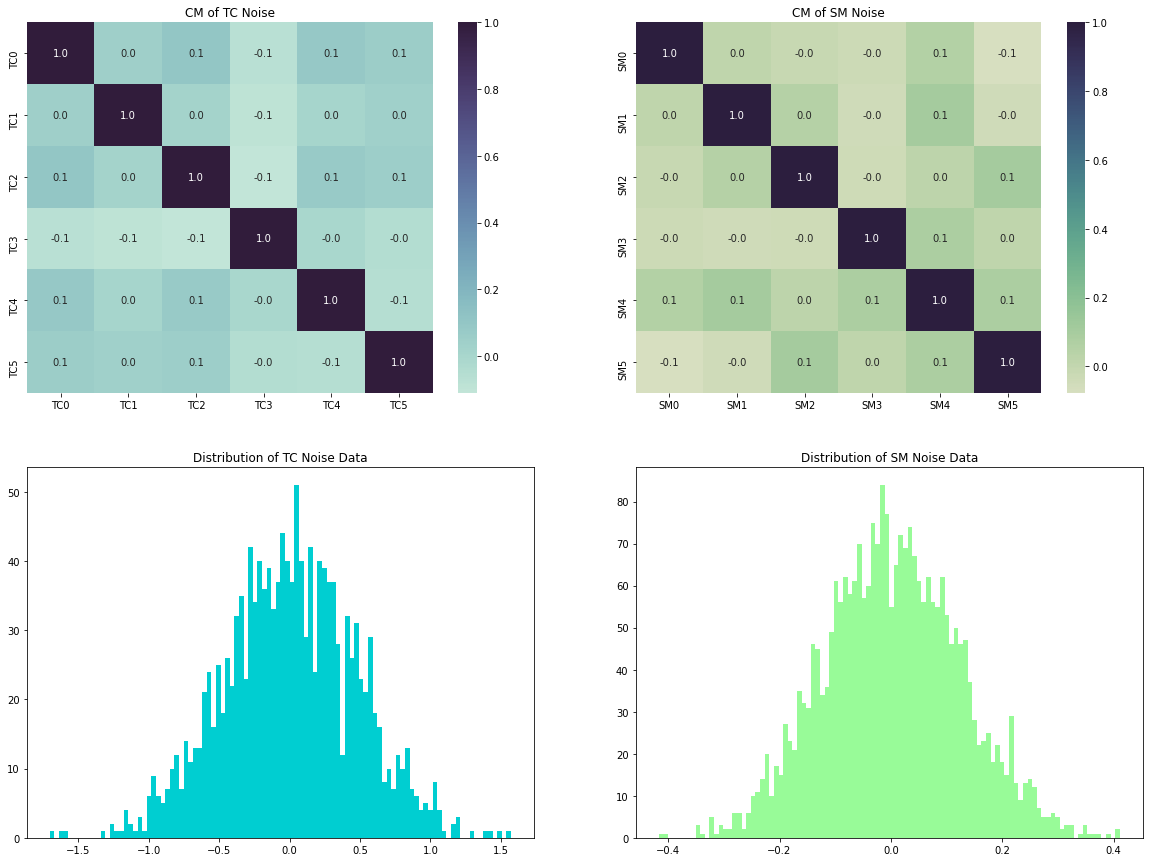

In [15]:
# plot correlation matrix for TC and SM noise
GammaTCdf = pd.DataFrame(GammaTC, columns = ["TC0", "TC1", "TC2", "TC3", "TC4", "TC5"])
GammaTCcorr_mat = GammaTCdf.corr()
GammaSMdf = pd.DataFrame(GammaSM.transpose(), columns = ["SM0", "SM1", "SM2", "SM3", "SM4", "SM5"])
GammaSMcorr_mat = GammaSMdf.corr()

fig, axes = plt.subplots(2, 2) 
fig.set_figheight(15)
fig.set_figwidth(20)

SMcolor = "palegreen"

sns.heatmap(GammaTCcorr_mat, cmap=TCcmap, annot = True, fmt='.1f', ax = axes[0][0])
axes[0][0].set_title("CM of TC Noise")
sns.heatmap(GammaSMcorr_mat, cmap=SMcmap, annot = True, fmt='.1f', ax = axes[0][1])
axes[0][1].set_title("CM of SM Noise")
axes[1][0].hist(TCnoise, bins=100, color = TCcolor)
axes[1][0].set_title("Distribution of TC Noise Data")
axes[1][1].hist(SMnoise, bins=100, color = SMcolor)
axes[1][1].set_title("Distribution of SM Noise Data")

plt.show()

In [16]:
GammaTCSM = np.matmul(GammaTC, GammaSM)

1.5

In [17]:
# generate dataset X
X = np.matmul(GammaTC + TC, GammaSM + SM)
TCGammaSM = np.matmul(TC, GammaSM)
SMGammaTC = np.matmul(GammaTC, SM)
print(X.shape)

(240, 441)


In [107]:
# take 100 sample from X
sampleX = random.sample(range(0, V), 100)
sampleXdf = pd.DataFrame(np.take(X, sampleX, 1))
sampleXdf.to_pickle("data/SampleX.pkl")

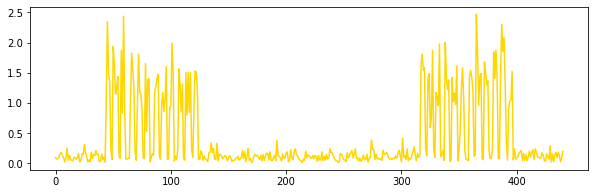

In [19]:
# ploting the variance of the 441 variables
Vvar = []
for i in range(V):
    Vvar.append(X[:, i].var())
fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(10)
plt.plot(Vvar, color = "gold")
plt.show()

In [20]:
# standardising X
OX = X
X = np.asmatrix(pd.DataFrame(X).astype(float).apply(zscore).to_numpy())

Question 2

2.1

In [21]:
def calculateD(A):
    D = np.matmul(X, A.transpose())
    return D

In [22]:
# X = DA + E
D = TC 
# estimate A and D using least square regression
ALSR = np.matmul(np.matmul(np.linalg.inv(np.matmul(D.transpose(),D)),D.transpose()), X)
print(f"check dim(SM) = dim(ALSR): {ALSR.shape == SM.shape}")
DLSR = calculateD(ALSR)
print(f"check dim(TC) = dim(DLSR): {DLSR.shape == TC.shape}")

check dim(SM) = dim(ALSR): True
check dim(TC) = dim(DLSR): True


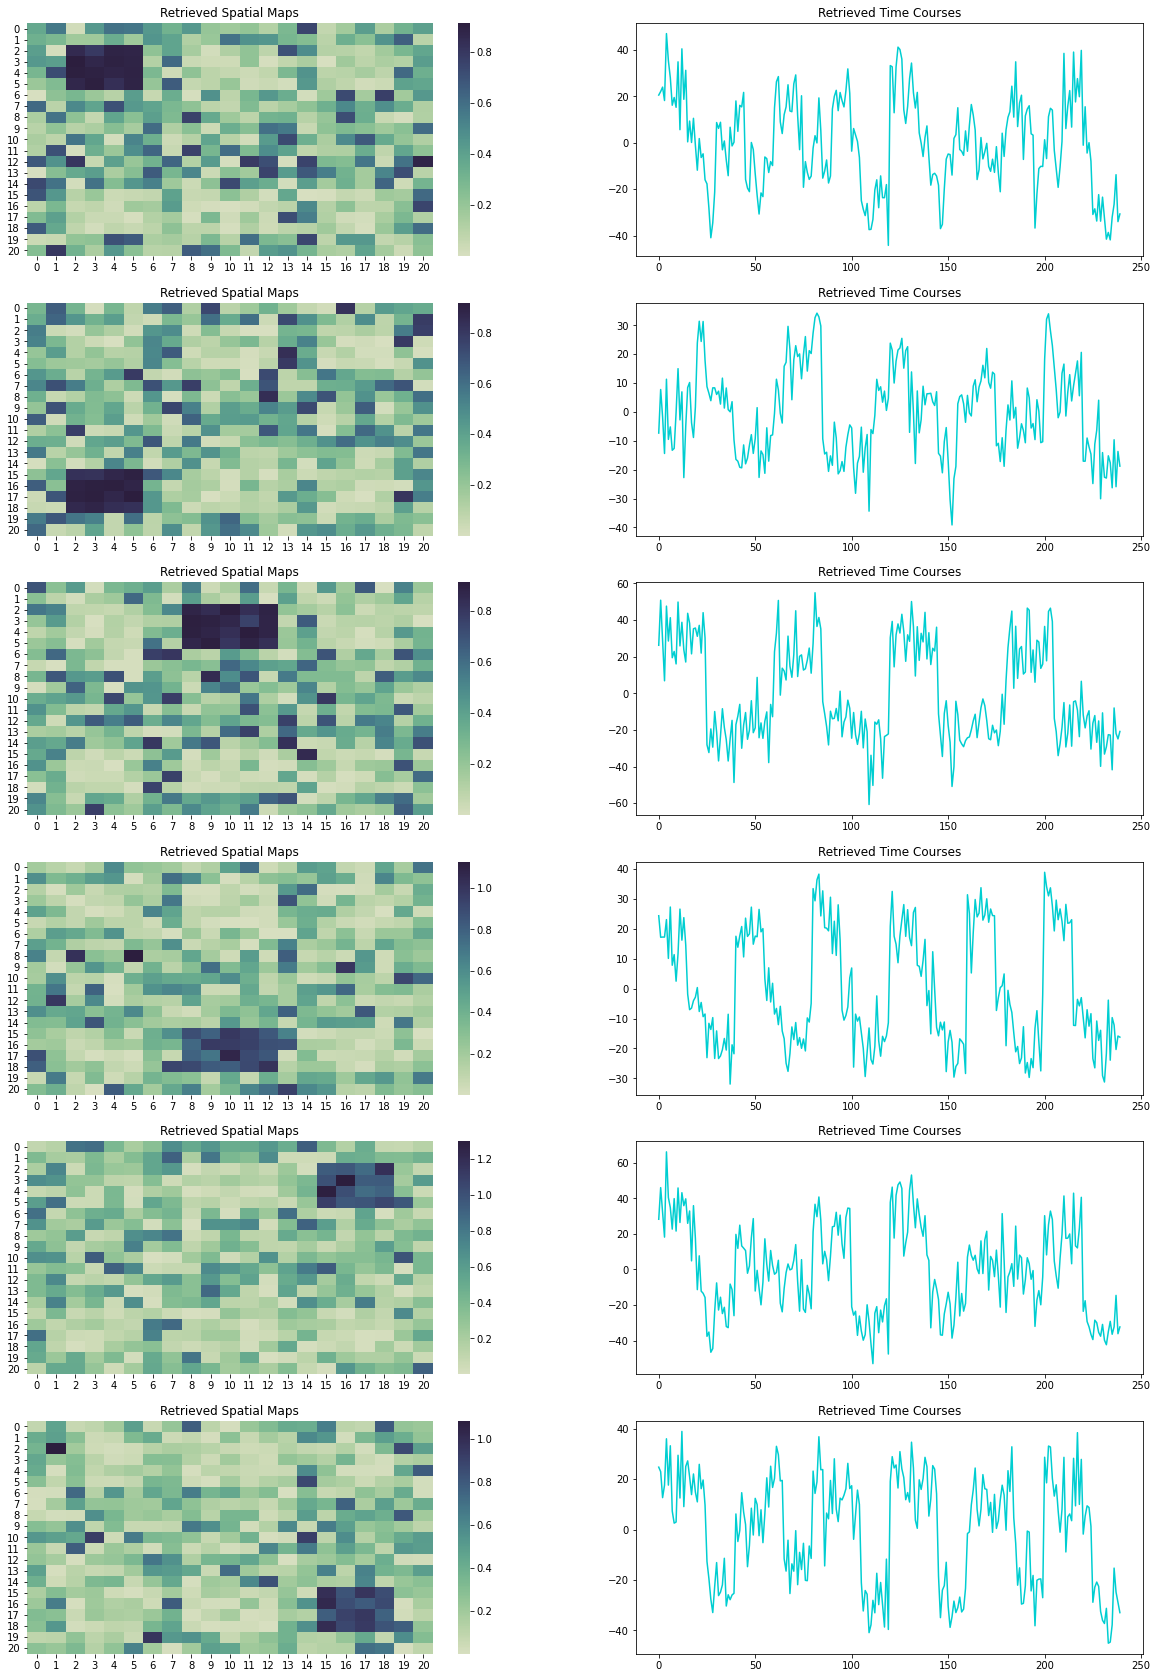

In [23]:
# plot the retrieved data set D and A using LSR
fig, axes = plt.subplots(6, 2) 
fig.set_figheight(30)
fig.set_figwidth(20)

absDLSR = calculateD(abs(ALSR))

for i in range(nsrcs):
    axes[i][0].set_title("Retrieved Spatial Maps")
    sns.heatmap(abs(ALSR[i]).reshape(x1,x2), cmap=SMcmap, ax = axes[i,0])
    axes[i][1].set_title("Retrieved Time Courses")
    axes[i][1].plot(x, absDLSR[:, i], color = TCcolor)
    
plt.show()


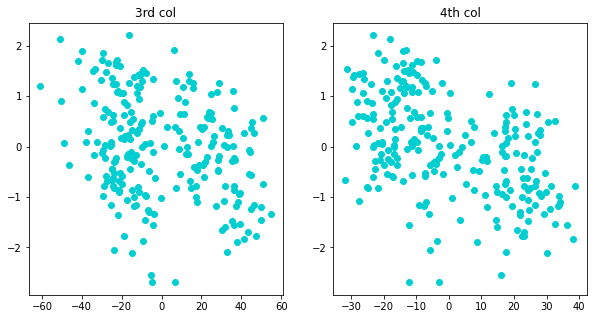

In [24]:
fig, axes = plt.subplots(1, 2) 
fig.set_figheight(5)
fig.set_figwidth(10)

axes[0].set_title("3rd col")
axes[0].scatter([absDLSR[:, 3-1]], [X[:, 30]], color = TCcolor)
axes[1].set_title("4th col")
axes[1].scatter([absDLSR[:,4-1]], [X[:, 30]], color = TCcolor)
plt.show()

2.2

In [25]:
# this function will find the correlation vector of given estimator and TC
def findcorrvectorD(estD, colname):
    estDdf = pd.DataFrame(estD, columns = colname)
    corrvdf = pd.concat([estDdf, TCdf], axis = 1)
    corr_mat = corrvdf.corr()
    important_corr = corr_mat.loc[colname][TCdf.columns]
    corrv = []
    for i in range(nsrcs):
        corrv.append(important_corr.iloc[i][i])
    
    return corrv


In [26]:
# find the correlation vector between TC and DLSR
cTLSR = findcorrvectorD(DLSR, ["LSRTC0", "LSRTC1", "LSRTC2", "LSRTC3", "LSRTC4", "LSRTC5"])
sum(cTLSR)

5.270257439421153

In [27]:
# perform ridge regression for a given value of lamdba
def ridge_regression(lam):
    penalty_term = lam*V
    ARR = np.matmul(np.matmul(np.linalg.inv(np.matmul(D.transpose(),D)+ penalty_term * np.identity(L)),D.transpose()), X)
    DRR = calculateD(ARR)
    
    return [lam, ARR, DRR]
    

In [28]:
# find the optimal lambda in given a range of value
def determine_rrlambda(lamrange):
    i  = lamrange[0]
    optimal_bound = 0
    optimal_lam = 0
    optimal_corrve = []
    incr = (lamrange[1] - lamrange[0])/10
    while i >= lamrange[0] and i <= lamrange[1]:
        regression_result = ridge_regression(i)
        ARR = regression_result[1]
        DRR = regression_result[2]
        

        RRcorrve = findcorrvectorD(DRR, ["RRTC0", "RRTC1", "RRTC2", "RRTC3", "RRTC4", "RRTC5"])
        if(sum(RRcorrve) > sum(optimal_corrve)):
            optimal_corrve = RRcorrve
            optimal_bound = optimal_lam
            optimal_lam = i
        i += incr
    
    return [optimal_bound, optimal_lam, optimal_corrve]    

In [29]:
# find the optimal lambda such that sum of cTRR > sum of cTLSR
i = 0
numiteration = 1
lamrange = [0, 1]
cTRR = []
optimal_rrlambda = 0
while i in range(numiteration) or i < sum(cTLSR):
    optimal_list = determine_rrlambda(lamrange)
    print(f"optimal lambda value in this iteration: {optimal_list[1]}")
    print(f"sum of corresponding correlation vector: {sum(optimal_list[2])}")
    lamrange[0] = optimal_list[0]
    lamrange[1] = optimal_list[1]
    if(sum(cTRR) < sum(optimal_list[2])):
        optimal_rrlambda = optimal_list[1]
        cTRR = optimal_list[2]
    i += 1
print(f"\n\nfinal optimal lamdba for RR: {optimal_rrlambda}")
print(f"corresponding correlation vector sum: {sum(cTRR)}")

optimal lambda value in this iteration: 0.30000000000000004
sum of corresponding correlation vector: 5.485483623146934
optimal lambda value in this iteration: 0.26000000000000006
sum of corresponding correlation vector: 5.486196939760068
optimal lambda value in this iteration: 0.25700000000000006
sum of corresponding correlation vector: 5.486201876576567
optimal lambda value in this iteration: 0.2567
sum of corresponding correlation vector: 5.4862019199898056
optimal lambda value in this iteration: 0.2566900000000001
sum of corresponding correlation vector: 5.486201920005496
optimal lambda value in this iteration: 0.2566890000000003
sum of corresponding correlation vector: 5.486201920001978


final optimal lamdba for RR: 0.2566900000000001
corresponding correlation vector sum: 5.486201920005496


In [30]:
# find the optimal ARR and DRR
optimal_rrlambda, ARR, DRR = ridge_regression(optimal_rrlambda)

correlation vector sum: 5.374151576137915


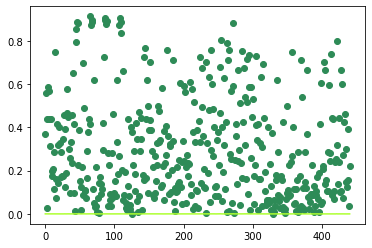

In [66]:
# plot for lambda = 1000
trylam = 1000
tryrr_result = ridge_regression(trylam)
tryARR = tryrr_result[1]
print(f"correlation vector sum: {sum(findcorrvectorD(tryrr_result[2], ['RRTC0', 'RRTC1', 'RRTC2', 'RRTC3', 'RRTC4', 'RRTC5']))}")
plt.scatter([range(V)], np.asarray(abs(ALSR[0, :])).flatten(), color = "seagreen")
plt.plot(np.asarray(abs(tryARR[0, :])).flatten(), color = "greenyellow")
plt.show()

2.3

In [32]:
# generate a random list of rho
overall_rho_range = [0, 100]
rho_range = [0, 5]
incr = 5
rho_list = [0]
while rho_range[1] <= overall_rho_range[1]:
    rho_list.append(random.randint(rho_range[0], rho_range[1])/100)
    rho_range = [rho_range[0] + incr, rho_range[1]+ incr]

In [33]:
# component wise max(0, x)
def pmax(A):
    final_matrix = np.zeros((nsrcs, 1))
    for i in range(nsrcs):
        if A[i] > 0:
            final_matrix[i] = A[i]
    return final_matrix

In [34]:
# perform lasso_regression with given X and rho
def lasso_regression(rho, newX, D):
    step = 1/(np.linalg.norm(np.matmul(D.transpose(),D))*1.1)
    thr = rho*N*step
    Ao = np.zeros((nsrcs, 1))
    A = np.zeros((nsrcs, 1))
    ALR = np.zeros((nsrcs, x1*x2))
    for k in range(x1*x2):
        A = Ao + step * np.matmul(D.transpose(),(newX[:, k] - np.matmul(D, Ao)))
        A = (1/(1+thr)) * (np.multiply(np.sign(A), pmax(abs(A) - thr)))
        for i in range(10):
            Ao = A
            A = Ao + step * np.matmul(D.transpose(),(newX[:, k] - np.matmul(D, Ao)))
            A = (1/(1+thr)) * (np.multiply(np.sign(A), pmax(abs(A) - thr)))
        ALR[:,k] = A.flatten()
    
    return ALR

In [35]:
# generate then standardised new X dataset
def generate_standardised_X(mu, varTC, varSM):
    newTCnoise = np.random.normal(mu, math.sqrt(varTC), size = N*nsrcs)
    newGammaTC = newTCnoise.reshape(240,6)
    newSMnoise = np.random.normal(mu, math.sqrt(varSM), size = nsrcs*V)
    newGammaSM = newSMnoise.reshape(6, 441)
    newX = np.matmul(newGammaTC + TC, newGammaSM + SM)
    newX = np.asmatrix(pd.DataFrame(newX).astype(float).apply(zscore).to_numpy())
    
    return newX
    


In [74]:
# calculate MSE of a LS model
def calculate_LR_MSE(rho, Xst):
    ALR = lasso_regression(rho, Xst, D)
    DLR = calculateD(ALR)
    MSE = np.square(Xst - np.matmul(DLR, ALR)).sum().sum()/N*V
    
    return MSE

In [77]:
# generate 10 new X
newX_list = []
for i in range(10):
    newX_list.append(generate_standardised_X(mu, varTC, varSM))

In [76]:
# create a dataframe to store all MSE for different dataset and rho
j = 0
LR_MSEdf = pd.DataFrame(columns = rho_list)
for col in rho_list:
    j += 1
    MSE_list = []
    for i in range(10):
        MSE_list.append(calculate_LR_MSE(col, newX_list[i]))
    print(f"{j}th rho:{col} with mean MSE = {np.mean(MSE_list)}")
    LR_MSEdf[col] = MSE_list

1th rho:0 with mean MSE = 31682417.00046154
2th rho:0.05 with mean MSE = 18086399.344319254
3th rho:0.06 with mean MSE = 16234792.411828712
4th rho:0.13 with mean MSE = 7566603.153453514
5th rho:0.19 with mean MSE = 3803289.5057223192
6th rho:0.23 with mean MSE = 2344727.211857646
7th rho:0.25 with mean MSE = 1824962.1741552849
8th rho:0.33 with mean MSE = 631733.701934027
9th rho:0.35 with mean MSE = 479327.54051856545
10th rho:0.41 with mean MSE = 218084.78572134193
11th rho:0.47 with mean MSE = 130870.30526575653
12th rho:0.53 with mean MSE = 121689.78459245537
13th rho:0.56 with mean MSE = 129524.6154282192
14th rho:0.64 with mean MSE = 159483.21454543874
15th rho:0.65 with mean MSE = 162990.6287504909
16th rho:0.7 with mean MSE = 177761.99556882068
17th rho:0.78 with mean MSE = 190924.5951370385
18th rho:0.81 with mean MSE = 193052.45793564303
19th rho:0.88 with mean MSE = 194464.69734117755
20th rho:0.92 with mean MSE = 194480.99970587454
21th rho:0.98 with mean MSE = 194481.0


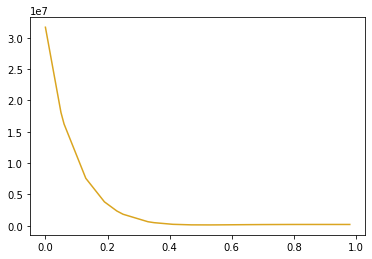

In [78]:
plt.plot(rho_list, LR_MSEdf.mean(), color = "goldenrod")
plt.show()

In [79]:
optimal_rho = LR_MSEdf.mean().idxmin()
optimal_rho

0.53

2.4

In [80]:
# find the optimal DLR and ALR
ALR = lasso_regression(optimal_rho, X, D)
DLR = calculateD(ALR)

In [81]:
# this function will find the correlation vector of given estimator and TC
def findcorrvectorA(estA, colname):
    estAdf = pd.DataFrame(estA.transpose(), columns = colname)
    corrvdf = pd.concat([estAdf, SMdf], axis = 1)
    corr_mat = corrvdf.corr()
    important_corr = corr_mat.loc[colname][SMdf.columns]
    corrv = []
    for i in range(nsrcs):
        corrv.append(important_corr.iloc[i][i])
    
    return corrv

In [82]:
cTRR = findcorrvectorD(DRR, ["RRTC0", "RRTC1", "RRTC2", "RRTC3", "RRTC4", "RRTC5"])
cSRR = findcorrvectorA(ARR, ["RRSM0", "RRSM1", "RRSM2", "RRSM3", "RRSM4", "RRSM5"])
cTLR = findcorrvectorD(DLR, ["LRTC0", "LRTC1", "LRTC2", "LRTC3", "LRTC4", "LRTC5"])
cSLR = findcorrvectorA(ALR, ["LRSM0", "LRSM1", "LRSM2", "LRSM3", "LRSM4", "LRSM5"])
cSLSR = findcorrvectorA(ALSR, ["LSRSM0", "LSRSM1", "LSRSM2", "LSRSM3", "LSRSM4", "LSRSM5"])

In [83]:
correlation_vector_df = pd.DataFrame(index = ["TC", "SM"], columns = ["LSR", "RR", "LR"])
correlation_vector_df.loc["TC"]["LSR"] = sum(cTLSR)
correlation_vector_df.loc["SM"]["LSR"] = sum(cSLSR)
correlation_vector_df.loc["TC"]["RR"] = sum(cTRR)
correlation_vector_df.loc["SM"]["RR"] = sum(cSRR)
correlation_vector_df.loc["TC"]["LR"] = sum(cTLR)
correlation_vector_df.loc["SM"]["LR"] = sum(cSLR)

In [84]:
correlation_vector_df

,LSR,RR,LR
TC,5.270257,5.486202,5.496164
SM,2.708326,2.597231,4.277772


In [108]:
pd.DataFrame(abs(ARR)).to_pickle("data/ARR.pkl")
pd.DataFrame(calculateD(abs(ARR))).to_pickle("data/DRR.pkl")
pd.DataFrame(abs(ALR)).to_pickle("data/ALR.pkl")
pd.DataFrame(calculateD(abs(ALR))).to_pickle("data/DLR.pkl")


2.5

In [86]:
ARR.shape

(6, 441)

In [98]:
U, eigenvalues, W = np.linalg.svd(TC, full_matrices=False)

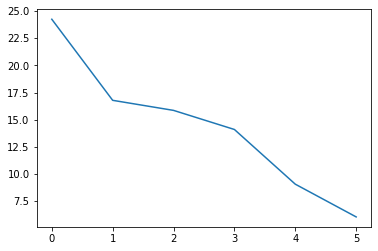

In [99]:
plt.plot(eigenvalues)
plt.show()

In [100]:
Z, Zeigenvalues, ZW = np.linalg.svd(U, full_matrices=False)

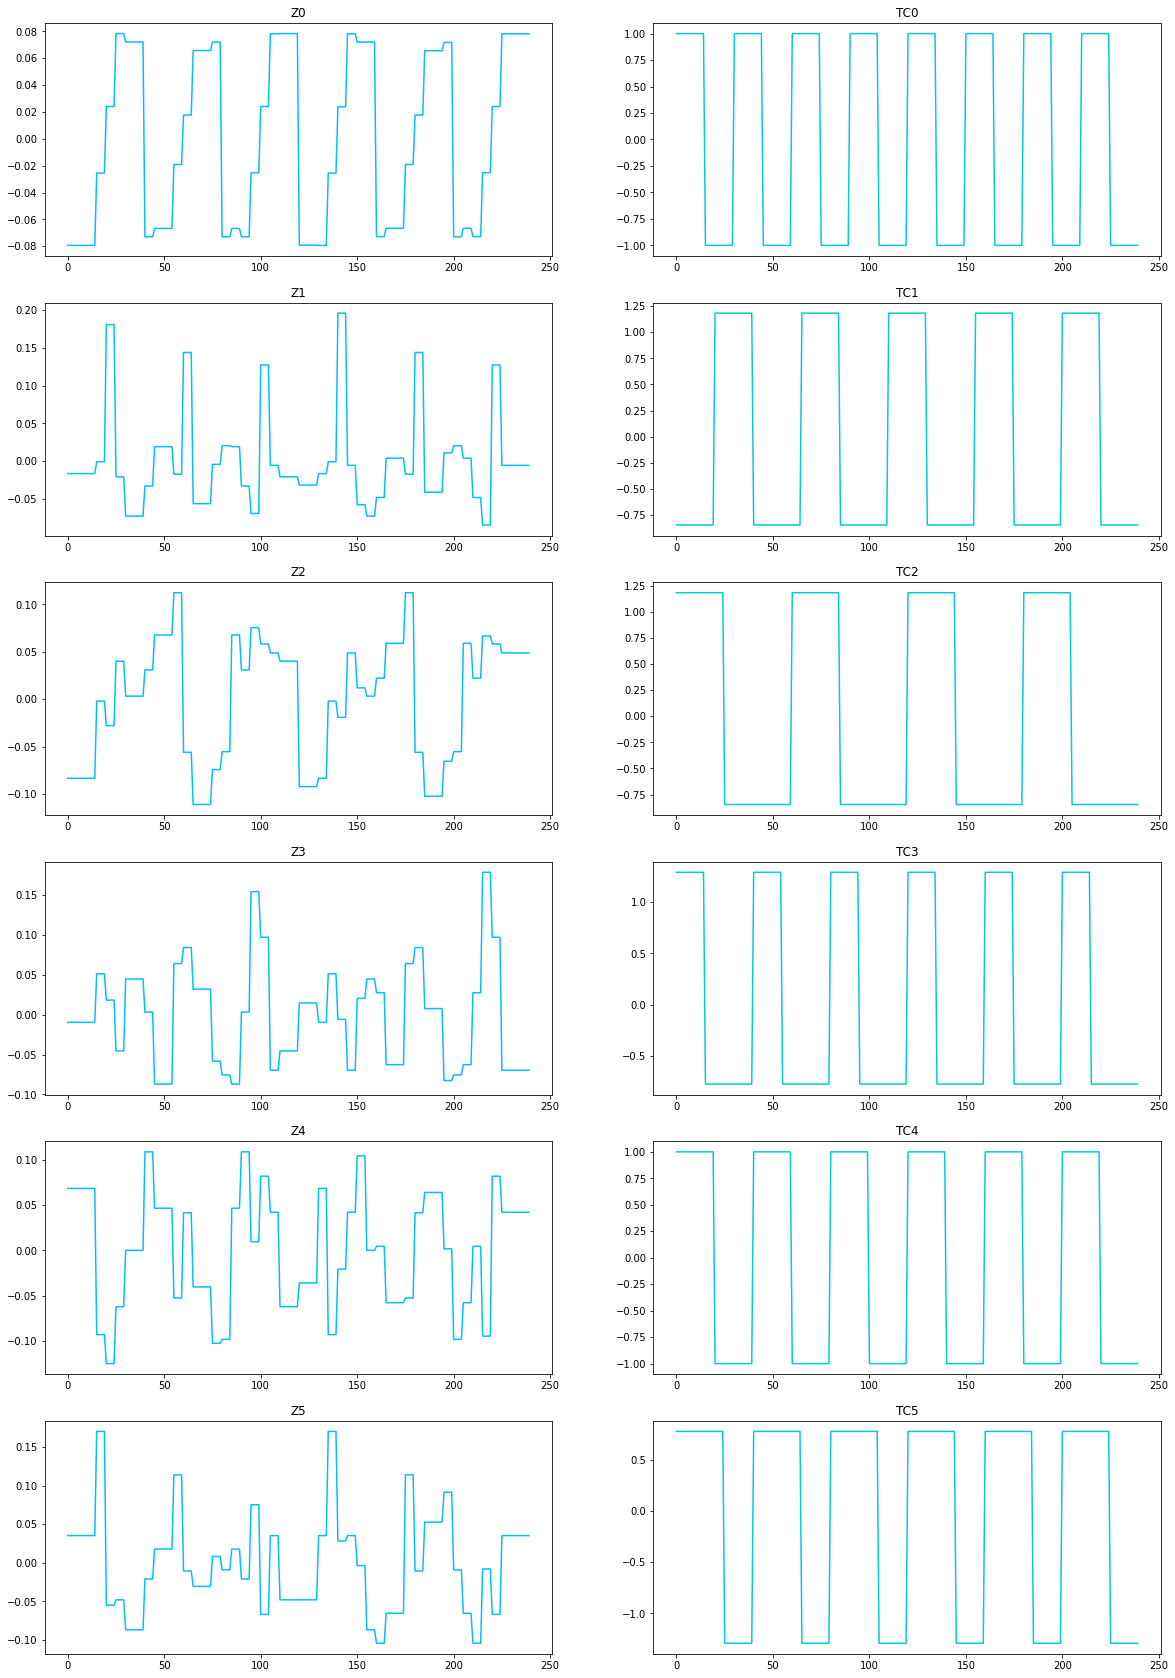

In [101]:
# plot Z and TCs
fig, axes = plt.subplots(6, 2) 
fig.set_figheight(30)
fig.set_figwidth(20)


for i in range(nsrcs):
    axes[i][0].set_title(f"Z{i}")
    axes[i][0].plot(x, Z[:,i], color = "deepskyblue")
    axes[i][1].set_title(f"TC{i}")
    axes[i][1].plot(x, TC[:, i], color = TCcolor)
    
plt.show()

In [109]:
APCR = lasso_regression(0.001, X, Z)
DPCR = calculateD(APCR)
pd.DataFrame(abs(APCR)).to_pickle("data/APCR.pkl")
pd.DataFrame(calculateD(abs(APCR))).to_pickle("data/DPCR.pkl")

In [103]:
pca = PCA(n_components=6, svd_solver='full')
pca.fit(TC)

PCA(n_components=6, svd_solver='full')

In [104]:
print(pca.explained_variance_ratio_)

[0.40844577 0.19580485 0.17480377 0.13821991 0.05720012 0.02552558]


In [105]:
print(pca.singular_values_ == eigen_values)

[False False False False False False]
